In [2]:
import requests
#from bs4 import BeautifulSoup
import time
import datetime
from tqdm.notebook import tqdm
import re
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
import numpy as np

In [3]:
df_seiseki = pd.read_csv('SEISEKI2018-2020.csv')
df_seiseki.info()

/Users/toshi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130750 entries, 0 to 130749
Data columns (total 47 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   年         130750 non-null  int64  
 1   月         130750 non-null  int64  
 2   日         130750 non-null  int64  
 3   回次        130750 non-null  int64  
 4   場所        130750 non-null  object 
 5   日次        130750 non-null  object 
 6   レース番号     130750 non-null  int64  
 7   略レース名     130750 non-null  object 
 8   クラスコード    130750 non-null  int64  
 9   芝・ダ       130750 non-null  object 
 10  トラックコード   130750 non-null  int64  
 11  距離        130750 non-null  int64  
 12  馬場状態      130750 non-null  object 
 13  馬名        130750 non-null  object 
 14  性別        130750 non-null  object 
 15  年齢        130750 non-null  int64  
 16  騎手        130750 non-null  object 
 17  斤量        130750 non-null  float64
 18  頭数        130750 non-null  int64  
 19  馬番        130750 non-null  int64  
 20  入先着順

In [3]:
df_seiseki.columns

Index(['年', '月', '日', '回次', '場所', '日次', 'レース番号', '略レース名', 'クラスコード', '芝・ダ',
       'トラックコード', '距離', '馬場状態', '馬名', '性別', '年齢', '騎手', '斤量', '頭数', '馬番',
       '入先着順', '異常コード', '確定着順', '着差タイム', '人気', '走破タイム(s)', '補正タイム', '通過順1角',
       '通過順2角', '通過順3角', '通過順4角', '上がり3F', '馬体重', '増減', '調教師', '所属', '賞金',
       '血統登録番号', '騎手コード', '調教師コード', '馬主名', '生産者名', '父馬名', '母馬名', '母の父',
       '単勝オッズ', 'PCI'],
      dtype='object')

In [4]:
# 確定着順が「異常コード」の時は省くことにする
df_seiseki = df_seiseki[df_seiseki['確定着順'] != 0]
df_seiseki['確定着順'].value_counts().sort_index()

1     9395
2     9377
3     9383
4     9382
5     9375
6     9365
7     9323
8     9208
9     8909
10    8467
11    7944
12    7277
13    6548
14    5800
15    4847
16    3613
17     774
18     580
Name: 確定着順, dtype: int64

In [5]:
df_seiseki['年齢'].value_counts()

3     56608
4     23231
2     19247
5     16217
6      8635
7      3793
8      1313
9       402
10       91
11       25
12        5
Name: 年齢, dtype: int64

In [6]:
# 開催場所を開催コードに変換する
prace_map = {
    '札幌': '01',
    '函館': '02',
    '福島': '03',
    '新潟': '04',
    '東京': '05',
    '中山': '06',
    '中京': '07',
    '京都': '08',
    '阪神': '09',
    '小倉': '10'
}
df_seiseki['prace_code'] = df_seiseki['場所'].map(lambda x: prace_map[x])
#df_seiseki.drop(['場所'], axis=1, inplace=True)  → LabelEncordingするから残す

In [7]:
df_seiseki['date'] = "20" + df_seiseki['年'].astype(str) + '-' \
    + df_seiseki['月'].astype(str).str.zfill(2) + '-'  \
    + df_seiseki['日'].astype(str).str.zfill(2)

In [8]:
#pd.to_datetime(df_seiseki['年']
from datetime import datetime, timedelta

#format(df_seiseki['年'], '0>4')

#df_seiseki[['年', '月', '日', 'prace_code', 'レース番号']]
# 年、月、日よりindexを作る
df_seiseki['race_id'] = "20" + df_seiseki['年'].astype(str) \
    + df_seiseki['月'].astype(str).str.zfill(2) \
    + df_seiseki['日'].astype(str).str.zfill(2) \
    + df_seiseki['prace_code'] \
    + df_seiseki['レース番号'].astype(str).str.zfill(2)

In [9]:
df_seiseki['race_id'] = df_seiseki['race_id'].astype(int)

In [10]:
# 着順を３着以内は「1」,４着以降は「0」へ変更
# この1と0が目的変数になる
clip_rank = lambda x: 1 if x<4 else 0
df_seiseki['gole_rank'] = df_seiseki['確定着順'].map(clip_rank)

In [11]:
df_seiseki.columns

Index(['年', '月', '日', '回次', '場所', '日次', 'レース番号', '略レース名', 'クラスコード', '芝・ダ',
       'トラックコード', '距離', '馬場状態', '馬名', '性別', '年齢', '騎手', '斤量', '頭数', '馬番',
       '入先着順', '異常コード', '確定着順', '着差タイム', '人気', '走破タイム(s)', '補正タイム', '通過順1角',
       '通過順2角', '通過順3角', '通過順4角', '上がり3F', '馬体重', '増減', '調教師', '所属', '賞金',
       '血統登録番号', '騎手コード', '調教師コード', '馬主名', '生産者名', '父馬名', '母馬名', '母の父',
       '単勝オッズ', 'PCI', 'prace_code', 'date', 'race_id', 'gole_rank'],
      dtype='object')

In [12]:
def drop_seiseki(seiseki):
    df = seiseki.copy()
    
    df.drop(['回次','日次','トラックコード','馬場状態','頭数','入先着順','着差タイム','騎手'], axis=1, inplace=True)
    df.drop(['年','月','日','prace_code','レース番号'], axis=1, inplace=True)
    df.drop(['確定着順', '通過順1角', '通過順2角', '通過順3角', '通過順4角', '異常コード'], axis=1, inplace=True)
    df.drop(['略レース名','馬名','血統登録番号','調教師','生産者名', '馬主名'], axis=1,inplace=True)
    df.drop(['父馬名', '母馬名', '母の父'], axis=1, inplace=True)
    df.drop(['賞金'], axis=1, inplace=True)
    # 予想データの関係で省くことになったカラムのリスト
    df.drop(['人気', '走破タイム(s)', '上がり3F', '馬体重', '増減', '単勝オッズ', 'PCI'], axis=1, inplace=True)
    #df.drop(['date', 'race_id'], axis=1, inplace=True) # これは日付でソート後に削除しなければならない
    
    return df

In [13]:
df_seiseki_d = drop_seiseki(df_seiseki)

In [14]:
x =  pd.DataFrame()
le = preprocessing.LabelEncoder()
le.fit(df_seiseki_d['場所'])
x['trainer_party'] = le.transform(df_seiseki_d['場所'])
df_seiseki_d['場所'] = x['trainer_party'].astype('category')

In [15]:
#df_seiseki_d = pd.get_dummies(df_seiseki, columns=['芝・ダ', '性別', '所属', '馬主名'])
df_seiseki_d = pd.get_dummies(df_seiseki_d, columns=['芝・ダ', '性別'])

In [16]:
x =  pd.DataFrame()
le = preprocessing.LabelEncoder()
le.fit(df_seiseki_d['所属'])
x['trainer_party'] = le.transform(df_seiseki_d['所属'])
df_seiseki_d['所属'] = x['trainer_party'].astype('category')

### 調教師データ、騎手データ追加

In [17]:
df_seiseki_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129567 entries, 0 to 130749
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   場所         128395 non-null  category
 1   クラスコード     129567 non-null  int64   
 2   距離         129567 non-null  int64   
 3   年齢         129567 non-null  int64   
 4   斤量         129567 non-null  float64 
 5   馬番         129567 non-null  int64   
 6   補正タイム      125351 non-null  float64 
 7   所属         128395 non-null  category
 8   騎手コード      129567 non-null  int64   
 9   調教師コード     129567 non-null  int64   
 10  date       129567 non-null  object  
 11  race_id    129567 non-null  int64   
 12  gole_rank  129567 non-null  int64   
 13  芝・ダ_ダ      129567 non-null  uint8   
 14  芝・ダ_芝      129567 non-null  uint8   
 15  性別_セ       129567 non-null  uint8   
 16  性別_牝       129567 non-null  uint8   
 17  性別_牡       129567 non-null  uint8   
dtypes: category(2), float64(2), int64(8), object

In [18]:
df_trainer = pd.read_csv('TRAINER202009.csv')
#df_trainer = df_trainer[['名前(ターゲット内表記)', '順位', '年齢', 'キャリア', '1着数', '2着数', '3着数', '着外数', '勝率', '連対率', '複勝率', 'コード']]
df_trainer = df_trainer[['順位', '年齢', 'キャリア', '1着数', '2着数', '3着数', '着外数', '勝率', '連対率', '複勝率', 'コード']]
df_trainer.rename(columns={'順位': '調教師_順位',
                           '年齢': '調教師_年齢',
                           'キャリア': '調教師_キャリア',
                           '1着数': '調教師_1着数',
                           '2着数': '調教師_2着数',
                           '3着数': '調教師_3着数',
                           '着外数': '調教師_着外数',
                           '勝率': '調教師_勝率',
                           '連対率': '調教師_連対率',
                           '複勝率': '調教師_複勝率'
                          }, inplace=True)
df_trainer = df_trainer.set_index('コード')
df_trainer

,調教師_順位,調教師_年齢,調教師_キャリア,調教師_1着数,調教師_2着数,調教師_3着数,調教師_着外数,調教師_勝率,調教師_連対率,調教師_複勝率
コード,,,,,,,,,,
1075,1,59,17.0,43.0,27.0,35.0,262.0,11.7,19.1,28.6
1061,2,57,20.0,37.0,15.0,14.0,111.0,20.9,29.4,37.3
1070,3,52,19.0,34.0,25.0,14.0,108.0,18.8,32.6,40.3
386,4,69,34.0,30.0,23.0,16.0,105.0,17.2,30.5,39.7
1157,5,38,5.0,30.0,17.0,20.0,191.0,11.6,18.2,26.0
...,...,...,...,...,...,...,...,...,...,...
5111,223,56,NaN,0.0,0.0,0.0,3.0,0.0,0.0,0.0
5625,224,51,NaN,0.0,0.0,0.0,3.0,0.0,0.0,0.0
1177,225,43,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0


In [19]:
df_jocky = pd.read_csv('JOCKY202009.csv')
df_jocky = df_jocky[['順位', '1着数', '2着数', '3着数', '着外数', '勝率', '連対率', '複勝率', 'コード']]
df_jocky.rename(columns={'順位': '騎手_順位',
                           '1着数': '騎手_1着数',
                           '2着数': '騎手_2着数',
                           '3着数': '騎手_3着数',
                           '着外数': '騎手_着外数',
                           '勝率': '騎手_勝率',
                           '連対率': '騎手_連対率',
                           '複勝率': '騎手_複勝率'
                          }, inplace=True)

df_jocky = df_jocky.set_index('コード') # 騎手コードをインデックスに設定
df_jocky

,騎手_順位,騎手_1着数,騎手_2着数,騎手_3着数,騎手_着外数,騎手_勝率,騎手_連対率,騎手_複勝率
コード,,,,,,,,
5339,1,135.0,85.0,62.0,239.0,25.9,42.2,54.1
1088,2,124.0,82.0,46.0,184.0,28.4,47.2,57.8
1014,3,84.0,62.0,58.0,263.0,18.0,31.3,43.7
1126,4,84.0,53.0,56.0,421.0,13.7,22.3,31.4
666,5,78.0,75.0,44.0,288.0,16.1,31.5,40.6
...,...,...,...,...,...,...,...,...
5171,167,0.0,0.0,0.0,8.0,0.0,0.0,0.0
5534,168,0.0,0.0,0.0,8.0,0.0,0.0,0.0
1046,169,0.0,0.0,0.0,11.0,0.0,0.0,0.0


In [20]:
def merge_jocky_and_trainer(df_base, df_j, df_t):
    df = df_base.copy()
    
    df = pd.merge(df, df_t, left_on='調教師コード', right_on='コード', how='left')
    df = pd.merge(df, df_j, left_on='騎手コード', right_on='コード', how='left')
    #df.shape
    return df

In [21]:
def split_data(df, test_size=0.3):
    
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)):]
    train = df.loc[train_id_list].drop(['date'], axis=1)
    test = df.loc[test_id_list].drop(['date'], axis=1)
    
    train.drop(['race_id'], axis=1, inplace=True) # dateカラムは使い終わったので削除
    test.drop(['race_id'], axis=1, inplace=True) # dateカラムは使い終わったので削除

    return train, test

In [22]:
df_seiseki_d = merge_jocky_and_trainer(df_seiseki_d, df_jocky, df_trainer)

In [23]:
#df_seiseki_d['賞金'] = df_seiseki_d['賞金']/100
#df_seiseki_d.drop(['賞金'], axis=1, inplace=True)

In [24]:
# 補正タイムを省いてみる

#df_seiseki_d.drop(['補正タイム'], axis=1, inplace=True)

In [25]:
df_seiseki_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129567 entries, 0 to 129566
Data columns (total 36 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   場所         128395 non-null  category
 1   クラスコード     129567 non-null  int64   
 2   距離         129567 non-null  int64   
 3   年齢         129567 non-null  int64   
 4   斤量         129567 non-null  float64 
 5   馬番         129567 non-null  int64   
 6   補正タイム      125351 non-null  float64 
 7   所属         128395 non-null  category
 8   騎手コード      129567 non-null  int64   
 9   調教師コード     129567 non-null  int64   
 10  date       129567 non-null  object  
 11  race_id    129567 non-null  int64   
 12  gole_rank  129567 non-null  int64   
 13  芝・ダ_ダ      129567 non-null  uint8   
 14  芝・ダ_芝      129567 non-null  uint8   
 15  性別_セ       129567 non-null  uint8   
 16  性別_牝       129567 non-null  uint8   
 17  性別_牡       129567 non-null  uint8   
 18  調教師_順位     126670 non-null  float64 
 19  調教

In [26]:
# 勾配ブースティング木
import lightgbm as lgb

train, test = split_data(df_seiseki_d, 0.3)
X_train = train.drop(['gole_rank'], axis=1)
y_train = train['gole_rank']
X_test = test.drop(['gole_rank'], axis=1)
y_test = test['gole_rank']

params = {
    'num_leaves': 33,
    'n_estimators': 150,
    #'class_weight': 'balanced',
    #'min_data_in_leaf': 3,
    'random_state': 100,
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values) # .valuesを付けないとエラーになる

/Users/toshi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


LGBMClassifier(n_estimators=150, num_leaves=33, random_state=100)

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from jupyterthemes import jtplot
#jtplot.style(theme='monokai')
    
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1] # aucを求めるためのメソッド。データは一列目だけ必要
y_pred = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

0.9773645501792755
0.9606104883971212


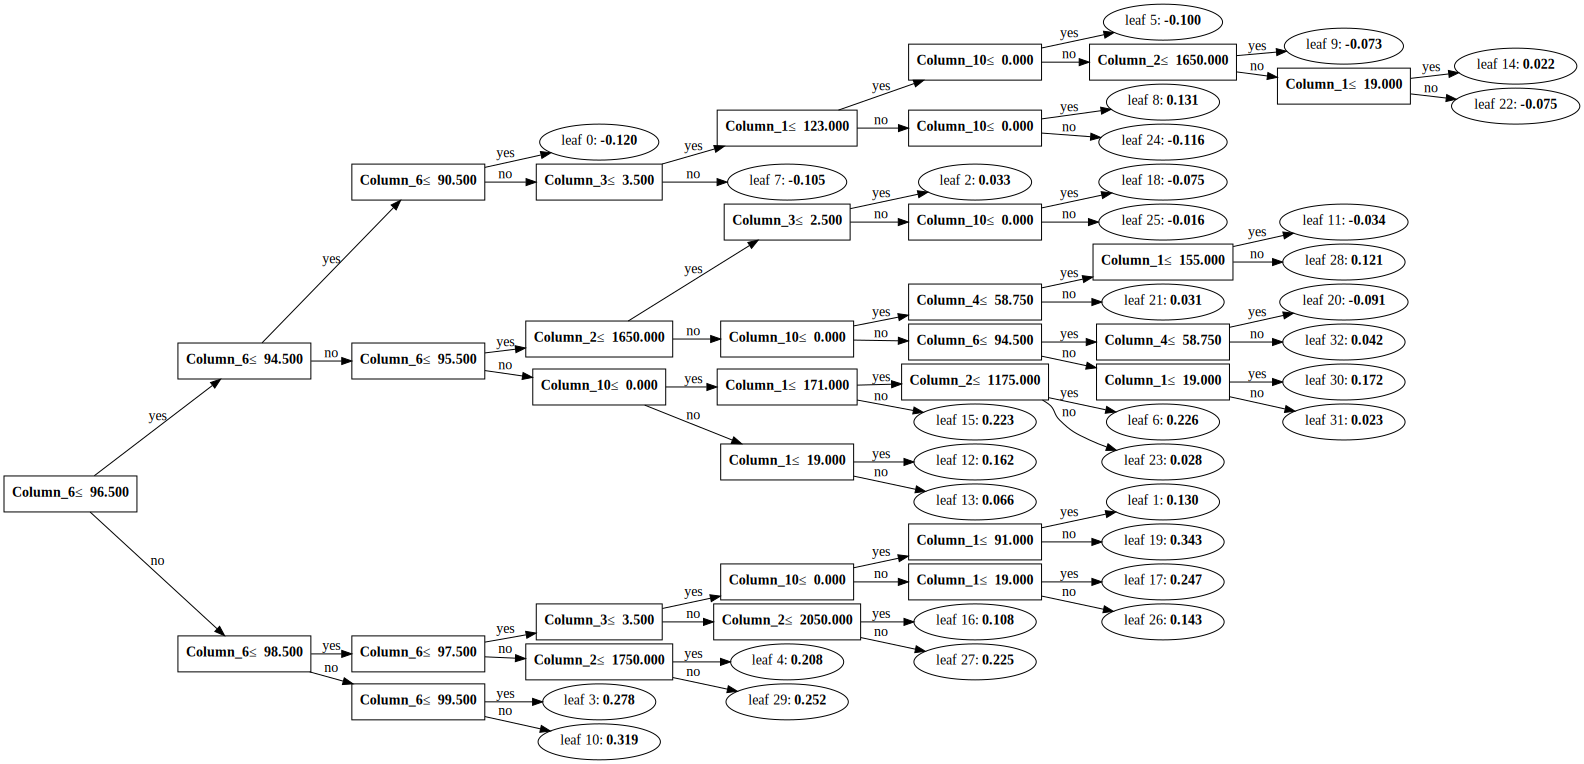

In [28]:
# brew install graphviz

import graphviz
lgb.create_tree_digraph(lgb_clf, 1)

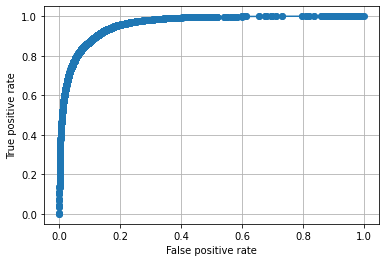

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid()
plt.show()

In [30]:
# 特徴量のうち、どれがどれだけ関係しているかを調べる
importances = pd.DataFrame(
    {'features': X_train.columns, 'importance': lgb_clf.feature_importances_}
)
importances.sort_values('importance', ascending=False)[:20]

,features,importance
6,補正タイム,658
1,クラスコード,404
2,距離,394
3,年齢,283
0,場所,213
5,馬番,208
21,調教師_着外数,200
8,騎手コード,173
29,騎手_着外数,151
10,芝・ダ_ダ,147


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

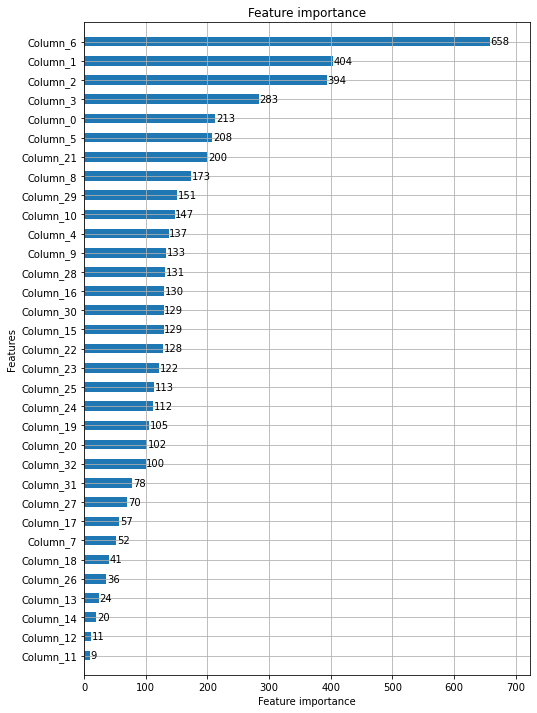

In [31]:
lgb.plot_importance(lgb_clf, height=0.5, figsize=(8,12))

In [32]:
### ここは実行しなくて良い ###

# クラスコード
race_class_map = {
    '未勝利': 7,
    '未出走': 11,
    '新馬': 15,
    '400万下': 19,
    '500万下': 23,
    '900万下': 39,
    '1000万下': 43,
    '1500万下': 63,
    '1600万下': 67,
    '重賞以外のオープン': 131,
    'グレード無し重賞': 147,
    'G3': 163,
    'G2': 179,
    'G1': 195
}
#df_seiseki['race_class'] = df_seiseki['レース名'].map(lambda x: race_class_map[x])
#df_seiseki.drop(['場所'], axis=1, inplace=True)

In [33]:
df_seiseki['略レース名'].describe()

count     129567
unique      1260
top          未勝利
freq       28240
Name: 略レース名, dtype: object

## 明日の予測

In [34]:
#df_next_pred1 = pd.read_csv('DI201003.CSV')
#df_next_pred1 = pd.read_csv('DI201004.CSV')
#df_next_pred1 = pd.read_csv('DI201010.csv')
#df_next_pred1 = pd.read_csv('DI201011.CSV')
df_next_pred1 = pd.read_csv('DI201017.CSV')


#df_next_pred1 = pd.read_csv('DI200927.CSV')
#df_next_pred1 = pd.read_csv('DI200926.CSV')


#df_next_pred1 = pd.read_csv('DI200921_戦歴1.CSV')
#df_next_pred1 = pd.read_csv('DI200921.CSV')
#df_next_pred1 = pd.read_csv('DI200920.CSV')
#df_next_pred1 = pd.read_csv('DI200919.CSV')
#df_next_pred2 = pd.read_csv('DI200921_戦歴2.CSV')

In [35]:
#df_next_pred1[['獲得本賞金', '獲得本賞金.1', '獲得本賞金.2', '獲得本賞金.3', '獲得本賞金.4']].sum(axis=1)

In [36]:
df_pred = df_next_pred1[['馬名','血統登録番号','性別','年齢(今回時年齢)','調教師','調教師コード','所属','馬主コード','総レース数','本賞金','収得賞金','父','母','母父', '生産者', '今回日付S','今回場所','今回レース番号','今回クラスコード','今回距離','今回芝・ダ','今回頭数','今回馬番','今回騎手','今回騎手コード','今回斤量', '補正タイム/補9']]

In [37]:
#df_next_pred1[['馬名','日付', '人気', '着順', '騎手', '斤量', '芝・ダート', '補正タイム/補9', '体重', '馬体重増減', '単勝オッズ', 'PCI']]
#df_next_pred1.iloc[:, 30:39]
#df_next_pred1.iloc[:, 34:35] # PCI
#df_pred['date'] = df_next_pred1['日付']
#df_pred.head()

In [38]:
df_pred.rename(columns={'年齢(今回時年齢)': '年齢',
                        '本賞金': '賞金',
                        '今回日付S': 'date',
                        '今回場所': '場所',
                        '今回レース番号': 'レース番号',
                        '今回クラスコード': 'クラスコード',
                        '今回距離': '距離',
                        '今回芝・ダ': '芝・ダ',
                        '今回頭数': '頭数',
                        '今回馬番': '馬番',
                        '今回騎手': '騎手',
                        '今回騎手コード': '騎手コード',
                        '今回斤量': '斤量',
                        '補正タイム/補9': '補正タイム'}, inplace=True)

/Users/toshi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pandas/core/frame.py:4301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
df_pred.head()

,馬名,血統登録番号,性別,年齢,調教師,調教師コード,所属,馬主コード,総レース数,賞金,...,レース番号,クラスコード,距離,芝・ダ,頭数,馬番,騎手,騎手コード,斤量,補正タイム
0,バイオレントブロー,2015103930,セ,5,佐々木晶,429,栗東,486800,22,5820,...,1,7,2850,障害・芝,13,1,白浜雄造,1035,60,NaN
1,ラパウィラ,2017104553,牡,3,中野栄治,1010,美浦,461008,6,70,...,1,7,2850,障害・芝,13,2,草野太郎,1113,58,69.0
2,アイアス,2016102967,セ,4,古賀史生,392,美浦,303031,23,0,...,1,7,2850,障害・芝,13,3,伴啓太,1149,60,NaN
3,グリニッチヴィレジ,2013103941,牝,7,天間昭一,1090,美浦,878800,47,2921,...,1,7,2850,障害・芝,13,4,蓑島靖典,1068,58,NaN
4,テイエムリボー,2015102163,牡,5,武英智,1161,栗東,356002,19,1760,...,1,7,2850,障害・芝,13,5,黒岩悠,1072,60,NaN


### 訓練データのカラムから削除するリスト
- '人気',
- '走破タイム(s)'
- '上がり3F'
- '馬体重'
- '増減'
- '単勝オッズ'
- 'PCI'


In [40]:
### この特徴量の形を目指す ###

#df_dummy = drop_seiseki(df_seiseki_d)
#df_dummy.columns
# -> Index(['クラスコード', '距離', '年齢', '斤量', '馬番', '人気', '走破タイム(s)', '補正タイム', '上がり3F',
#       '馬体重', '増減', '騎手コード', '調教師コード', '単勝オッズ', 'PCI', 'date', 'race_id',
#       'gole_rank', '芝・ダ_ダ', '芝・ダ_芝', '性別_セ', '性別_牝', '性別_牡', '所属_地', '所属_外',
#       '所属_栗', '所属_美'],
#      dtype='object')

In [41]:
X_pred = df_pred.reindex(columns=['場所', 'クラスコード', '距離', '斤量', '年齢', '馬番', '賞金', '補正タイム', '騎手コード', '調教師コード', '芝・ダ', '性別', '所属'])

In [42]:
x =  pd.DataFrame()
le = preprocessing.LabelEncoder()
le.fit(X_pred['場所'])
x['trainer_party'] = le.transform(X_pred['場所'])
X_pred['場所'] = x['trainer_party'].astype('category')

In [43]:
gain_mark = lambda x: x if len(x)==2 else x[0:2]
X_pred['斤量'] = X_pred['斤量'].map(gain_mark).astype(float)

In [44]:
#df_test = X_pred_d[X_pred_d['補正タイム']==' --']
#
#def supplementary_time_revise(tr):
#    if tr == ' --':
#        return 0.0
#    else:
#        return tr
#df_test['補正タイム'] = df_test['補正タイム'].map(supplementary_time_revise)

stime_revise = lambda x: 0 if x == ' --' else x
X_pred['補正タイム'] = X_pred['補正タイム'].map(stime_revise).astype(float)

In [45]:
def tarf_dart_select(gnd):
    if '障' in gnd:
        return False
    else:
        return True

# 障害戦は、'芝・ダ'カラムのデータを欠損値扱いにして、あとでデータをdropする
X_pred['芝・ダ'] = X_pred['芝・ダ'].map(lambda x: np.nan if '障' in x else x )
#fd.isnull().sum()
#X_pred_d[X_pred['芝・ダ']=='ダート']
#X_pred_d['芝・ダ'].value_counts()
#for data in X_pred_d['芝・ダ']:
#    #print(tarf_dart_select(data))
X_pred.dropna(how='all', axis=1)

,場所,クラスコード,距離,斤量,年齢,馬番,賞金,補正タイム,騎手コード,調教師コード,芝・ダ,性別,所属
0,1,7,2850,60.0,5,1,5820,NaN,1035,429,NaN,セ,栗東
1,1,7,2850,58.0,3,2,70,69.0,1113,1010,NaN,牡,美浦
2,1,7,2850,60.0,4,3,0,NaN,1149,392,NaN,セ,美浦
3,1,7,2850,58.0,7,4,2921,NaN,1068,1090,NaN,牝,美浦
4,1,7,2850,60.0,5,5,1760,NaN,1072,1161,NaN,牡,栗東
...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,0,43,1400,50.0,3,7,2020,94.0,1182,1157,芝,牝,栗東
465,0,43,1400,55.0,5,8,3665,95.0,1093,1161,芝,牝,栗東
466,0,43,1400,57.0,7,9,3950,90.0,1037,1140,芝,牡,栗東
467,0,43,1400,55.0,4,10,4220,97.0,1116,1066,芝,牝,栗東


In [46]:
X_pred_d = pd.get_dummies(X_pred, columns=['芝・ダ', '性別'])

In [47]:
x =  pd.DataFrame()
le = preprocessing.LabelEncoder()
le.fit(X_pred_d['所属'])
x['trainer_party'] = le.transform(X_pred_d['所属'])
X_pred_d['所属'] = x['trainer_party'].astype('category')

In [48]:
X_pred_d = merge_jocky_and_trainer(X_pred_d, df_jocky, df_trainer)

In [49]:
# 補正タイムを省いてみる
#X_pred_d.drop(['補正タイム'], axis=1, inplace=True)
# 補正タイムを省いてみる
X_pred_d.drop(['賞金'], axis=1, inplace=True)

In [50]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90697 entries, 31108 to 85123
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   場所        90697 non-null  category
 1   クラスコード    90697 non-null  int64   
 2   距離        90697 non-null  int64   
 3   年齢        90697 non-null  int64   
 4   斤量        90697 non-null  float64 
 5   馬番        90697 non-null  int64   
 6   補正タイム     87728 non-null  float64 
 7   所属        90697 non-null  category
 8   騎手コード     90697 non-null  int64   
 9   調教師コード    90697 non-null  int64   
 10  芝・ダ_ダ     90697 non-null  uint8   
 11  芝・ダ_芝     90697 non-null  uint8   
 12  性別_セ      90697 non-null  uint8   
 13  性別_牝      90697 non-null  uint8   
 14  性別_牡      90697 non-null  uint8   
 15  調教師_順位    87803 non-null  float64 
 16  調教師_年齢    87803 non-null  float64 
 17  調教師_キャリア  85974 non-null  float64 
 18  調教師_1着数   86059 non-null  float64 
 19  調教師_2着数   86059 non-null  float64 
 20  調教

In [51]:
X_pred_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469 entries, 0 to 468
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   場所        469 non-null    category
 1   クラスコード    469 non-null    int64   
 2   距離        469 non-null    int64   
 3   斤量        469 non-null    float64 
 4   年齢        469 non-null    int64   
 5   馬番        469 non-null    int64   
 6   補正タイム     365 non-null    float64 
 7   騎手コード     469 non-null    int64   
 8   調教師コード    469 non-null    int64   
 9   所属        469 non-null    category
 10  芝・ダ_ダート   469 non-null    uint8   
 11  芝・ダ_芝     469 non-null    uint8   
 12  性別_セ      469 non-null    uint8   
 13  性別_牝      469 non-null    uint8   
 14  性別_牡      469 non-null    uint8   
 15  調教師_順位    469 non-null    int64   
 16  調教師_年齢    469 non-null    int64   
 17  調教師_キャリア  469 non-null    float64 
 18  調教師_1着数   469 non-null    float64 
 19  調教師_2着数   469 non-null    float64 
 20  調教師_3着数   

In [52]:
y_pred_d = lgb_clf.predict(X_pred_d)

In [53]:
y_pred_d

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [54]:
## 自信度を出してみる
#y_pred_train = lgb_clf.predict_proba(X_train)[:, 1] # aucを求めるためのメソッド。データは一列目だけ必要
#y_pred = lgb_clf.predict_proba(X_pred_d)[:, 1]
y_pred_prob = lgb_clf.predict_proba(X_pred_d)[:, 1]
y_pred_prob
#print(roc_auc_score(y_train, y_pred_train))
#print(roc_auc_score(y_test, y_pred))

array([1.29229860e-01, 6.80221415e-05, 1.20846101e-01, 1.26496224e-01,
       8.26479917e-02, 1.65308417e-01, 6.74891789e-02, 9.96113408e-02,
       4.34314900e-03, 1.42304684e-01, 9.41708801e-01, 7.46445807e-02,
       7.57449674e-02, 4.46938466e-04, 2.95443999e-04, 5.16449326e-01,
       5.04512580e-04, 7.88729518e-05, 8.31627639e-05, 9.09490439e-01,
       5.33333330e-03, 6.18092185e-05, 4.61850136e-03, 1.63661018e-03,
       5.94946047e-03, 1.90295496e-02, 8.09557717e-04, 3.98698792e-03,
       2.23992623e-03, 5.57152073e-05, 3.49648554e-02, 3.38713972e-02,
       2.13928308e-04, 1.46771111e-04, 4.33200780e-03, 3.25912241e-03,
       4.17461884e-03, 4.26332429e-03, 3.76722744e-03, 2.04749401e-04,
       6.51467250e-05, 1.25156243e-01, 2.27977406e-01, 3.64440836e-01,
       6.60794753e-02, 8.75231070e-02, 4.20075452e-04, 9.20553510e-02,
       1.39964883e-01, 5.93680987e-02, 8.62963601e-02, 6.20679195e-03,
       7.04492058e-03, 6.99898173e-03, 5.97942593e-03, 5.53273092e-03,
      

In [55]:
race_list = df_pred[['年齢','date', '場所', 'レース番号', '距離', '芝・ダ', '頭数', '馬番', '騎手', '斤量']]
victory_road = pd.concat([race_list, pd.Series(y_pred_d)], axis=1)
victory_road.rename(columns={0: '馬券'}, inplace=True)
victory_road = pd.concat([victory_road, pd.Series(y_pred_prob)], axis=1)
victory_road.rename(columns={0: '自信度'}, inplace=True)

In [56]:
victory_road

,年齢,date,場所,レース番号,距離,芝・ダ,頭数,馬番,騎手,斤量,馬券,自信度
0,5,2020.10.17,新潟,1,2850,障害・芝,13,1,白浜雄造,60,0,0.129230
1,3,2020.10.17,新潟,1,2850,障害・芝,13,2,草野太郎,58,0,0.000068
2,4,2020.10.17,新潟,1,2850,障害・芝,13,3,伴啓太,60,0,0.120846
3,7,2020.10.17,新潟,1,2850,障害・芝,13,4,蓑島靖典,58,0,0.126496
4,5,2020.10.17,新潟,1,2850,障害・芝,13,5,黒岩悠,60,0,0.082648
...,...,...,...,...,...,...,...,...,...,...,...,...
464,3,2020.10.17,京都,12,1400,芝,11,7,泉谷楓真,50▲,0,0.007344
465,5,2020.10.17,京都,12,1400,芝,11,8,藤岡佑介,55,0,0.021355
466,7,2020.10.17,京都,12,1400,芝,11,9,太宰啓介,57,0,0.000747
467,4,2020.10.17,京都,12,1400,芝,11,10,藤岡康太,55,0,0.172106


In [57]:
victory_road['date'][0]

'2020.10.17'

In [58]:
victory_road.to_csv('{}+++.csv'.format(victory_road['date'][0]))

## XGBoost

In [130]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer, f1_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'kappa': make_scorer(cohen_kappa_score)
}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [131]:
model = xgb.XGBClassifier(max_depth=50,
                          learning_rate=0.16,
                          min_child_weight=1,
                          n_estimators=200)
scores_xgb = cross_validate(model,
                            X_train.values,
                            y_train.values,
                            cv=skf,
                            n_jobs=-1,
                            scoring=scoring)

/Users/toshi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/toshi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/toshi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/toshi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklear

In [132]:
import pprint

pprint.pprint("XGBoost:{}".format(scores_xgb))
pprint.pprint("XGBoost_accuracy:{}".format(scores_xgb['test_accuracy'].mean()))
pprint.pprint("XGBoost_kappa:{}".format(scores_xgb['test_kappa'].mean()))

("XGBoost:{'fit_time': array([488.43579793, 488.93064809, 488.22749686, "
 '488.51020098,\n'
 '       490.27425885, 488.61023116, 495.17046595, 495.00242686,\n'
 "       343.2271142 , 342.4414649 ]), 'score_time': array([2.5818851 , "
 '3.41872883, 2.92979789, 3.95749879, 1.58557701,\n'
 '       1.81745386, 2.13405609, 2.82320786, 1.47748971, 1.41030717]), '
 "'test_accuracy': array([0.91324   , 0.91092493, 0.9123484 , 0.91300992, "
 '0.91289967,\n'
 '       0.91068475, 0.91719043, 0.91410299, 0.90914103, 0.91531591]), '
 "'train_accuracy': array([0.99987749, 0.99987749, 0.99988974, 0.99987749, "
 '0.99988974,\n'
 '       0.99990199, 0.99988974, 0.99987749, 0.99988974, 0.99985299]), '
 "'test_kappa': array([0.73984398, 0.73235308, 0.73580954, 0.73691544, "
 '0.73966788,\n'
 '       0.73356467, 0.75347498, 0.74256713, 0.7292611 , 0.74859299]), '
 "'train_kappa': array([0.99964052, 0.99964052, 0.99967648, 0.99964055, "
 '0.99967651,\n'
 '       0.99971244, 0.99967649, 0.99964055, 0.99967

In [133]:
scores_xgb

/Users/toshi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/toshi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_kappa'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([488.43579793, 488.93064809, 488.22749686, 488.51020098,
        490.27425885, 488.61023116, 495.17046595, 495.00242686,
        343.2271142 , 342.4414649 ]),
 'score_time': array([2.5818851 , 3.41872883, 2.92979789, 3.95749879, 1.58557701,
        1.81745386, 2.13405609, 2.82320786, 1.47748971, 1.41030717]),
 'test_accuracy': array([0.91324   , 0.91092493, 0.9123484 , 0.91300992, 0.91289967,
        0.91068475, 0.91719043, 0.91410299, 0.90914103, 0.91531591]),
 'train_accuracy': array([0.99987749, 0.99987749, 0.99988974, 0.99987749, 0.99988974,
        0.99990199, 0.99988974, 0.99987749, 0.99988974, 0.99985299]),
 'test_kappa': array([0.73984398, 0.73235308, 0.73580954, 0.73691544, 0.73966788,
        0.73356467, 0.75347498, 0.74256713, 0.7292611 , 0.74859299]),
 'train_kappa': array([0.99964052, 0.99964052, 0.99967648, 0.99964055, 0.99967651,
        0.99971244, 0.99967649, 0.99964055, 0.9996765 , 0.99956867])}

In [134]:
model.fit(X_train.values, y_train.values) # .valuesを付けないとエラーになる

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.16,
       max_delta_step=0, max_depth=50, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [135]:
y_pred_train_xgb = model.predict_proba(X_train)[:, 1] # aucを求めるためのメソッド。データは一列目だけ必要
y_pred_xgb = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train_xgb))
print(roc_auc_score(y_test, y_pred_xgb))

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields 場所, 所属

In [136]:
y_pred_d_xgb = model.predict(X_pred_d)
y_pred_d_xgb

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields 場所, 所属

In [152]:
target = [int(1.0/i*10) if i < 4 else 0 for i in df_seiseki['確定着順']]

In [ ]:
# 参考

max_position = 20
lgbm_params = {
    'objective': 'lambdarank', # ランキング学習のアルゴリズムに設定する
    'metric': 'ndcg', # 評価指標 ndcgは検索結果リストの上位何件を評価指数に用いるか、というパラメータを持っている
    'lambdarank_truncation_level': 10,
    'ndcg_eval_at': [1, 2, 3], # ndcg@10, ndcg@5, ndcg@20 が算出される
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'boosting_type': 'gbdt',
    'random_state': 0,
}
train = lgb.Dataset(train_data, train_target, group=train_query)
valid = lgb.Dataset(val_data, val_target, reference=lgtrain, group=val__query)
model = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=100,
    valid_sets=valid,
    valid_names=['train', 'valid'],
    early_stopping_rounds=20,
    verbose_eval=5
)